In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_context('poster')
%matplotlib inline

mpg = sns.load_dataset('mpg')
iris = sns.load_dataset('iris')

In [2]:
def Facet_List_Columns(figlevel, **kwargs):
    """
    A wrapper function to show how a list of columns could be handled in faceting.
    To facet by a list of columns, a special 'columns_list' must be passed as either 'x' or 'y'
    to indicate whether the listed variables should be plotted on the x or y axis.
    
    This is a proof of concept - a proper implementation would be embedded in the function.
    
    Inputs:
    figlevel: a seaborn figure-level charting function (e.g. sns.relplot)
    **kwargs: all arguments required to drive the appropriate figure-level function.
    
    Returns: g - a seaborn FacetGrid with the plots drawn on it
    """
    
    # preprocess the data in case of faceting by column
    facet_by_col = False
    
    if type(kwargs.get('row')) == list or type(kwargs.get('col')) == list:
        facet_by_col = True
        # make sure one of 'x' or 'y' is the special 'columns_list'
        if (kwargs.get('x') == 'columns_list') == (kwargs.get('y') == 'columns_list'):
            raise ValueError ("When passing a list of dataframe columns, 'columns_list' must be on x or y axis")
        # make sure the user passed only one list of columns
        if type(kwargs.get('row')) == list and type(kwargs.get('col')) == list:
            raise ValueError ("For plotting columns against columns, use pairplot")
        # determine if df columns are to be facet columns or facet rows
        if type(kwargs.get('row')) == list:
            facet_by = 'row'
            facet_columns = kwargs.get('row')
            kwargs['row'] = 'dummy_for_listed_columns'
        else:
            facet_by = 'col'
            facet_columns = kwargs.get('col')
            kwargs['col'] = 'dummy_for_listed_columns'
    
    if not set(facet_columns).issubset(set(kwargs['data'].columns)):
        raise ValueError ("Not all listed columns present in data")
    
    if facet_by_col:
        # melt the provided data along the desired columns
        facet_column_indices = kwargs['data'].columns.isin(facet_columns)
        melted = pd.melt(kwargs['data'], id_vars=kwargs['data'].columns[~facet_column_indices],
                        value_vars=kwargs['data'].columns[facet_column_indices],
                        var_name='dummy_for_listed_columns',value_name='columns_list')

        # remove the data from kwargs so it doesn't fight with the melted data
        kwargs['data'] = melted
    
    # generate the figure using the core function
    g = figlevel(**kwargs)
    
    # with the figure generated, need to adjust the way titles are written
    
    # deterimine whether margin_titles was requested
    try:
        margin_titles = kwargs['facet_kws'].get('margin_titles')
    except KeyError:
        margin_titles = False
    
    # adjust the way facet columns are written above each axes
    
    # if df columns are on facet columns we need to know whether to write the row labels in the margin
    if facet_by=='col' and kwargs.get('row') is not None and not margin_titles:
        g.set_titles(kwargs['row'] + " = {row_name}")
    elif facet_by=='col' and kwargs.get('row') is not None and margin_titles:
        g.set_titles(col_template='', row_template=kwargs['row'] + " = {row_name}")
    # if df_col is on the rows it doesn't matter - col labels always go above
    elif facet_by=='row' and kwargs.get('col') is not None:
        g.set_titles(col_template=kwargs['col'] + " = {col_name}")
    # if df_col is in the columns and there are no rows, remove titles
    else:
        g.set_titles('')
        
    # write the proper label on the proper axis
    for index, data in g.facet_data():
        if kwargs.get('x') == 'columns_list':
            g.facet_axis(*index).set(xlabel=data.dummy_for_listed_columns.iloc[0])
        else:
            g.facet_axis(*index).set(ylabel=data.dummy_for_listed_columns.iloc[0])
    
    return g

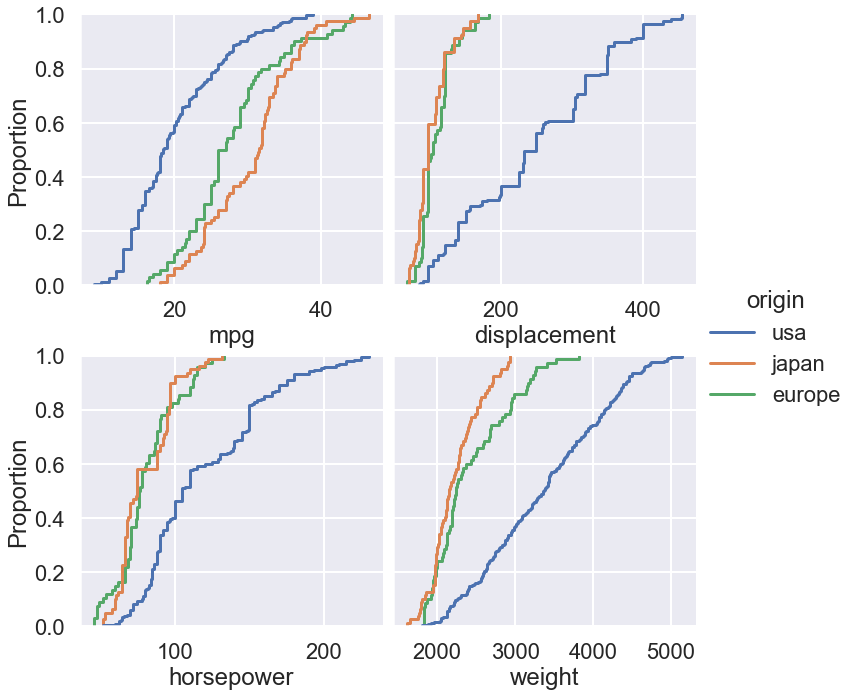

In [3]:
mpg_vars = ['mpg', 'displacement', 'horsepower', 'weight']
Facet_List_Columns(sns.displot, data=mpg, x='columns_list', col=mpg_vars, col_wrap=2,
                kind='ecdf', hue='origin', facet_kws={'sharex':False});

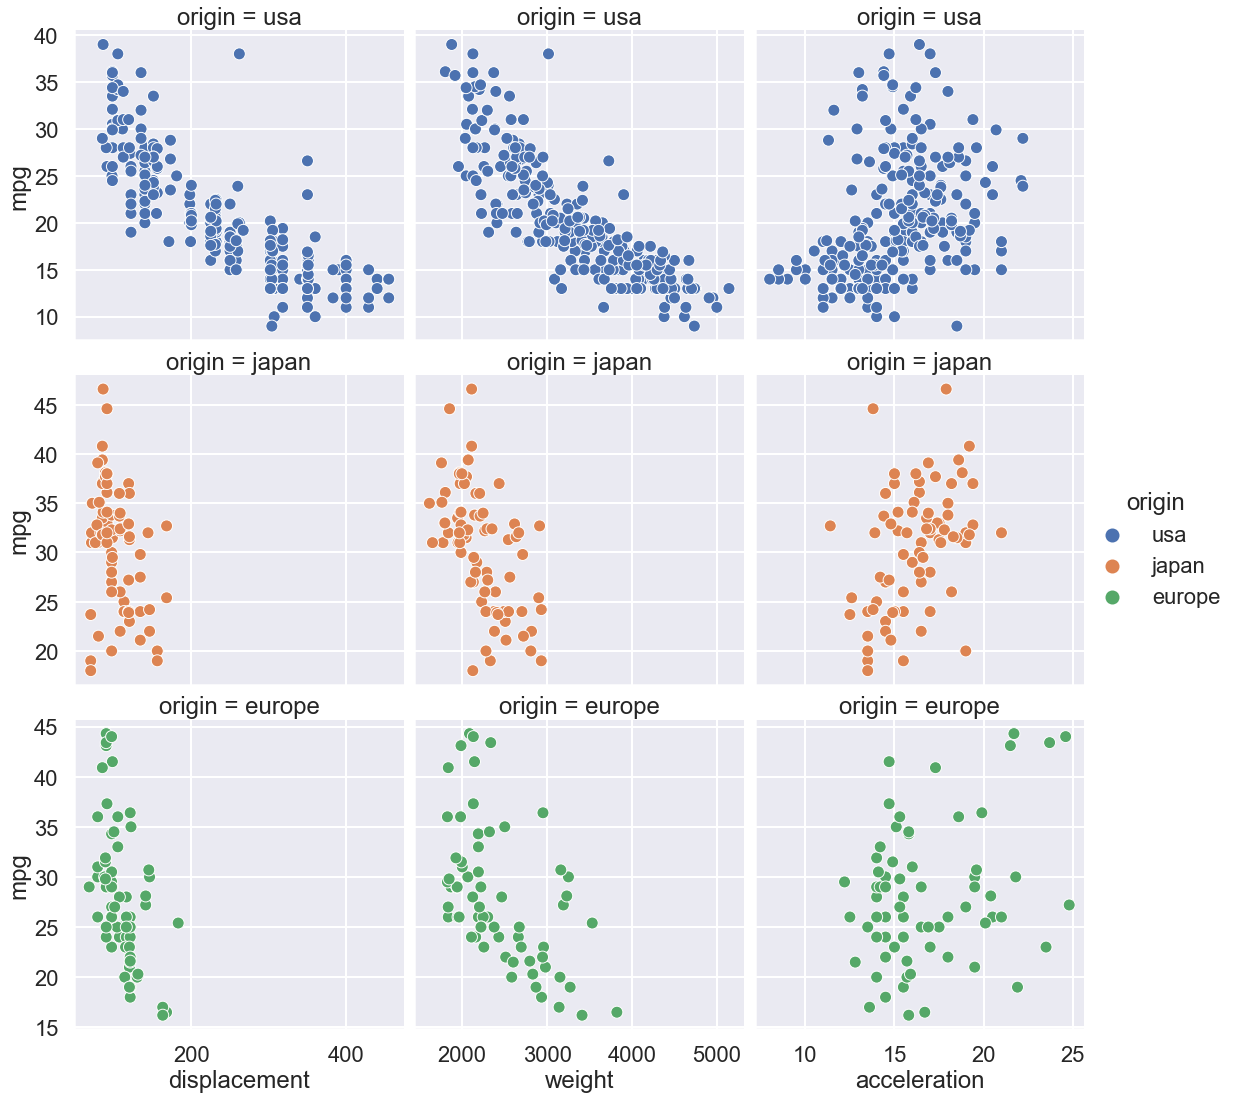

In [4]:
Facet_List_Columns(sns.relplot, data=mpg, y='mpg', x='columns_list',
                   col=['displacement', 'weight', 'acceleration'],
                   row='origin', hue='origin',
                   facet_kws={'sharex':'col', 'sharey': 'row'},
                   kind='scatter');

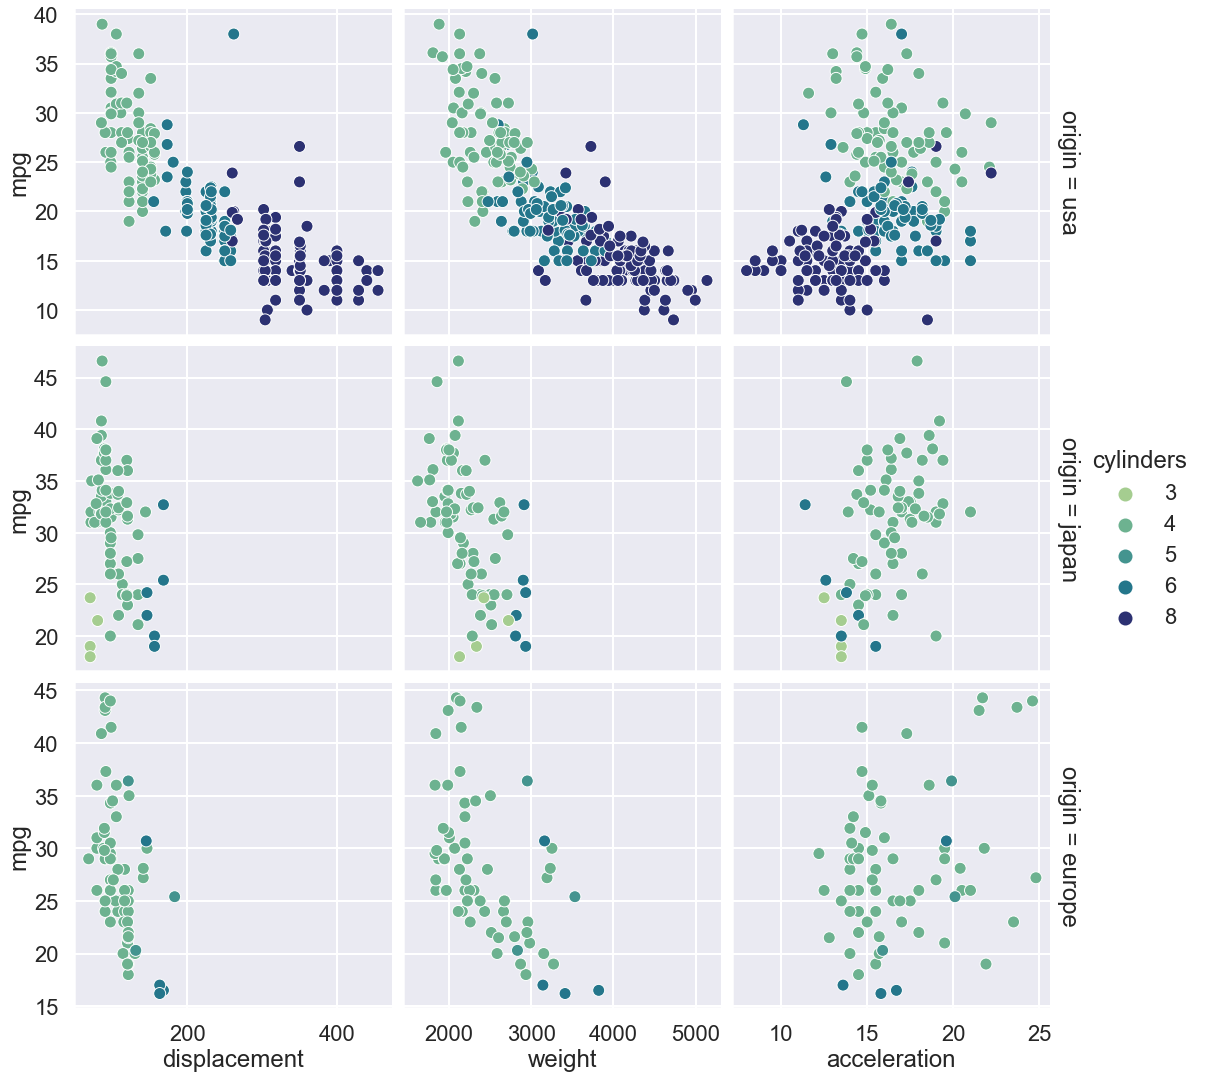

In [5]:
Facet_List_Columns(sns.relplot, data=mpg, y='mpg', x='columns_list',
                   col=['displacement', 'weight', 'acceleration'],
                   row='origin', hue='cylinders',
                   facet_kws={'sharex':'col', 'sharey': 'row', 'margin_titles':True},
                   kind='scatter', palette='crest');

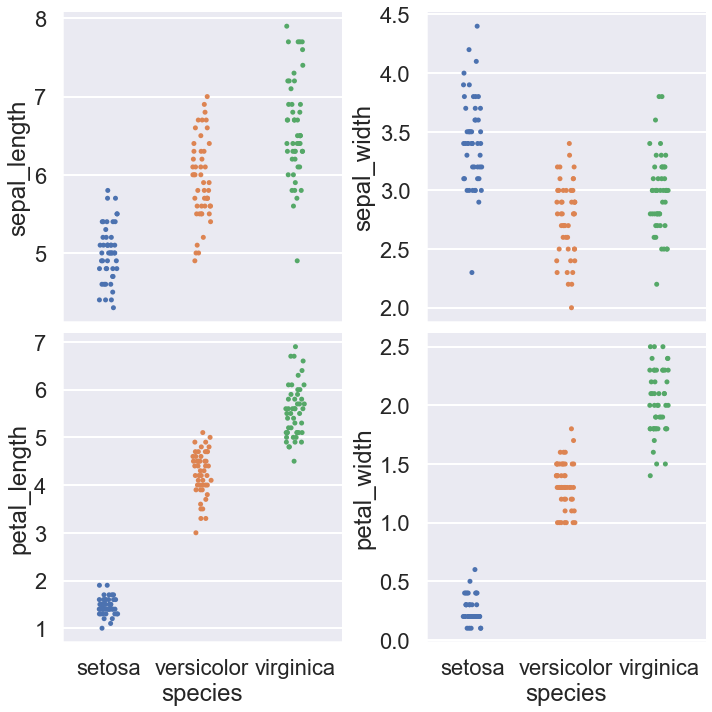

In [6]:
g = Facet_List_Columns(sns.catplot, data=iris,  x='species', y='columns_list',
                       col=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
                       col_wrap=2, hue='species', sharey=False, kind='strip')
g.tight_layout();